# M/EEG data processing with MNE-Python

## Hi everyone !

I'm Yann Harel, and today I'll run you through some tutorials inspired by [those](https://jasmainak.github.io/mne-workshop-brown/readme.html) of [Mainak Jas](https://jasmainak.github.io/) to teach you the basics of MNE-Python, a library built on a rich open-source ecosystem (numpy, pandas, scikit-learn, etc...) that allows the manipulation of electrophysiological data. 

## Quick overview :

- Introduction
 - What are M/EEG signals ?
 - Basic MNE concepts
- Raw objects
- Typical usecase : a basic pre-processing pipeline

## Electrophysiology
Direct recordings of neuronal activity.   
Brain-electrophysiology measures the temporal and spatial summation of pyramidal's cells post-synaptic potentials.

![cortex pps](https://s3.amazonaws.com/classconnection/110/flashcards/9630110/png/epsp_and_ipsp-150BF6053845B391CBE-thumb400.png)

### EEG
Hardware | Signals
- | - 
![eeg_headset](https://rcoyne99.files.wordpress.com/2014/06/eegdog.png) | ![eeg_signal](https://www.researchgate.net/profile/Domenico_Mirarchi/publication/319368720/figure/fig1/AS:613829591445505@1523359787840/Example-of-an-EEG-Signal_Q320.jpg)

### iEEG
Stereotactic EEG | ECoG
- | - 
![stereotactic](https://www.researchgate.net/publication/342204738/figure/fig1/AS:905679032287233@1592942116679/A-patient-undergoing-invasive-EEG-monitoring-with-stereotactic-depth-electrodes-had-a_Q320.jpg) | ![ECOG](http://www.medgadget.com/img/laser_neuro_x220.jpg)

### MEG
![meg_signal](http://ilabs.uw.edu/sites/default/files/squid.jpg)

## M/EEG time series
- sampling frequency usually between 200 and 2000 Hz, sometimes more
- often analyzed in the spectral domain
- can be used for source reconstruction

## MNE-Python
A set of tools to handle datafiles, process and analyze them, generate figures reports etc...
![eeg_swissknife](https://i.ibb.co/y0Rnw9T/eeg-swissknfife.png)

### Data objects
- [raw]()
- [epochs]()
- [evoked]()
- [time_frequency]()
- and others...


### Core idea
Objects contains the data + some metadata, and operations or functions are applied by using various [methods](https://docs.python.org/3/tutorial/classes.html#method-objects), i.e. functions that are specific to certain objects. 

# Now let's dive into it !
Starting with a few imports

In [1]:
#this line is required in order to plot the figures inside the notebook
%matplotlib inline 

# now import mne and some utilitaries
import mne
import os.path as op
from matplotlib import pyplot as plt



The [Raw](https://martinos.org/mne/stable/generated/mne.io.Raw.html) data structure: continuous data
=============================================================

Continuous data is stored in objects of type [Raw](https://martinos.org/mne/stable/generated/mne.io.Raw.html).
The core data structure is simply a 2D numpy array (channels × samples)
(in memory or loaded on demand) combined with an
[Info](https://martinos.org/mne/stable/generated/mne.Info.html#mne.Info) object (`.info` attribute)
(see [The Info data structure](https://martinos.org/mne/stable/auto_tutorials/plot_info.html#tut-info-objects)).  
The most common way to load continuous data is from a .fif file. For more
information on [loading data from other formats](https://martinos.org/mne/stable/manual/io.html#ch-convert), or
creating it [from scratch](https://martinos.org/mne/stable/auto_tutorials/plot_creating_data_structures.html#tut-creating-data-structures).




In [2]:
# Load an example dataset, the preload flag loads the data into memory now:
data_path = op.join(mne.datasets.sample.data_path(), 'MEG',
                    'sample', 'sample_audvis_raw.fif')
raw = mne.io.read_raw_fif(data_path, preload=True)
raw.set_eeg_reference('average', projection=True)  # set EEG average reference

Opening raw data file C:\Users\yhare\mne_data\MNE-sample-data\MEG\sample\sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Reading 0 ... 166799  =      0.000 ...   277.714 secs...
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.


<Raw | sample_audvis_raw.fif, 376 x 166800 (277.7 s), ~481.8 MB, data loaded>

Some may experience troubles loading the data, if an error about progress bars pops up after the previous cell,   
try these lines in your terminal (with the mne-tuto environment activated) and restart the notebook :
```
conda install -c conda-forge ipywidgets
jupyter nbextension enable --py widgetsnbextension
```

Information about the channels contained in the [Raw](https://martinos.org/mne/stable/generated/mne.io.Raw.html)
object is contained in the [Info](https://martinos.org/mne/stable/generated/mne.Info.html#mne.Info) attribute.
This is essentially a dictionary with a number of relevant fields (see
[The Info data structure](https://martinos.org/mne/stable/auto_tutorials/plot_info.html#tut-info-objects)).



In [3]:
# Give the sample rate
print('sample rate:', raw.info['sfreq'], 'Hz')
# Give the size of the data matrix
print('%s channels x %s samples' % (len(raw), len(raw.times)))

sample rate: 600.614990234375 Hz
166800 channels x 166800 samples


Indexing data
-------------

To access the data stored within [Raw]((https://martinos.org/mne/stable/generated/mne.io.Raw.html)) objects,
it is possible to index the [Raw](https://martinos.org/mne/stable/generated/mne.io.Raw.html) object.

Indexing a [Raw](https://martinos.org/mne/stable/generated/mne.io.Raw.html) object will 
return two arrays: 
* an array of times, 
* the data representing those timepoints. 
    
This works even if the data is _not preloaded_, in which case the data will be
read from disk when indexing.

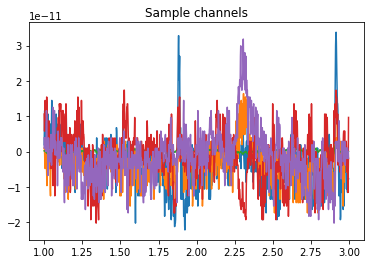

In [4]:
# Extract data from the first 5 channels, from 1 s to 3 s.
sfreq = raw.info['sfreq']
data, times = raw[:5, int(sfreq * 1):int(sfreq * 3)]
_ = plt.plot(times, data.T)
_ = plt.title('Sample channels')

Selecting subsets of channels and samples
-----------------------------------------

It is possible to use more intelligent indexing to extract data, using
channel names, types or time ranges.

In [5]:
meg_only = raw.copy().pick_types(meg=True)
eeg_only = raw.copy().pick_types(meg=False, eeg=True)

Removing projector <Projection | Average EEG reference, active : False, n_channels : 59>
Removing projector <Projection | PCA-v1, active : False, n_channels : 102>
Removing projector <Projection | PCA-v2, active : False, n_channels : 102>
Removing projector <Projection | PCA-v3, active : False, n_channels : 102>


The MEG flag in particular lets you specify a string for more specificity

In [6]:
grad_only = raw.copy().pick_types(meg='grad')

Removing projector <Projection | PCA-v1, active : False, n_channels : 102>
Removing projector <Projection | PCA-v2, active : False, n_channels : 102>
Removing projector <Projection | PCA-v3, active : False, n_channels : 102>
Removing projector <Projection | Average EEG reference, active : False, n_channels : 59>


Or you can use custom channel names

In [7]:
pick_chans = ['MEG 0112', 'MEG 0111', 'MEG 0122', 'MEG 0123']
specific_chans = raw.copy().pick_channels(pick_chans)
print(meg_only)
print(eeg_only)
print(grad_only)
print(specific_chans)

Removing projector <Projection | Average EEG reference, active : False, n_channels : 59>
<Raw | sample_audvis_raw.fif, 305 x 166800 (277.7 s), ~391.4 MB, data loaded>
<Raw | sample_audvis_raw.fif, 59 x 166800 (277.7 s), ~78.0 MB, data loaded>
<Raw | sample_audvis_raw.fif, 203 x 166800 (277.7 s), ~261.4 MB, data loaded>
<Raw | sample_audvis_raw.fif, 4 x 166800 (277.7 s), ~8.0 MB, data loaded>


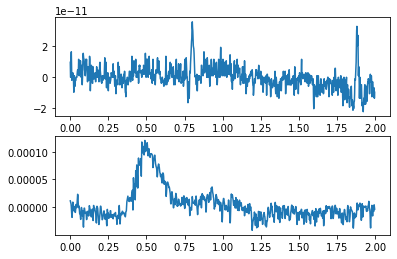

In [8]:
# Let's plot a sample of both eeg and meg signals
f, (a1, a2) = plt.subplots(2, 1)
eeg, times = eeg_only[0, :int(sfreq * 2)]
meg, times = meg_only[0, :int(sfreq * 2)]
a1.plot(times, meg[0])
a2.plot(times, eeg[0])
del eeg, meg, meg_only, grad_only, eeg_only, data, specific_chans

Notice the different scalings of these types

You can restrict the data to a specific time range

In [9]:
raw = raw.crop(0, 50)  # in seconds
print('New time range from', raw.times.min(), 's to', raw.times.max(), 's')

New time range from 0.0 s to 50.00041705299622 s


And drop channels by name

In [10]:
nchan = raw.info['nchan']
raw = raw.drop_channels(['MEG 0241', 'EEG 001'])
print('Number of channels reduced from', nchan, 'to', raw.info['nchan'])

Number of channels reduced from 376 to 374


Concatenating  [Raw](https://martinos.org/mne/stable/generated/mne.io.Raw.html) objects
--------------------------------------------------

[Raw](https://martinos.org/mne/stable/generated/mne.io.Raw.html) objects can be concatenated in time by using the
[raw.append](https://martinos.org/mne/dev/generated/mne.io.Raw.html#mne.io.Raw.append) function. For this to work, they must have the same number of channels and their [Info](https://martinos.org/mne/stable/generated/mne.Info.html#mne.Info) structures should be compatible.



In [11]:
# Create multiple Raw objects
raw1 = raw.copy().crop(0, 10)
raw2 = raw.copy().crop(10, 20)
raw3 = raw.copy().crop(20, 40)

# Concatenate in time (also works without preloading)
raw1.append([raw2, raw3])
print('Time extends from', raw1.times.min(), 's to', raw1.times.max(), 's')

Time extends from 0.0 s to 40.00399655463821 s


Visualizing Raw data
--------------------
All of the plotting method names start with `plot`. If you’re using IPython console, you can just
write `raw.plot` and ask the interpreter for suggestions with a tab key.



To visually inspect your raw data, you can use:

Setting up low-pass filter at 40 Hz

IIR filter parameters
---------------------
Butterworth lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 40.00 Hz: -6.02 dB



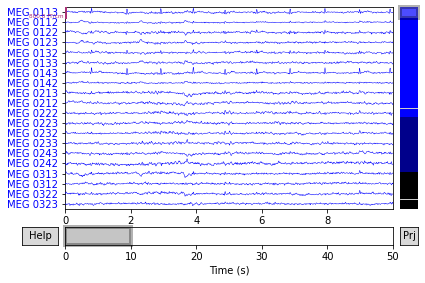

In [12]:
raw.plot(block=True, lowpass=40);

We can also plot the PSD to inspect:
* Power line
* Bad channels
* Head position indicator coils
* Whether data is filtered or not

Removing projector <Projection | Average EEG reference, active : False, n_channels : 59>
Effective window size : 3.410 (s)


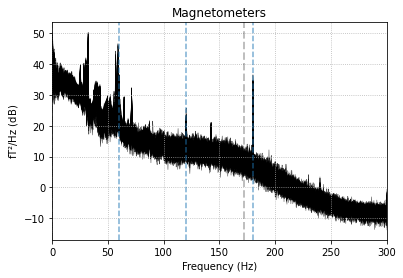

In [13]:
fig, ax = plt.subplots(1, 1)
raw.copy().pick_types(meg='mag').plot_psd(spatial_colors=False, show=False,
                                          ax=ax);
for freq in [60., 120., 180.]:
    ax.axvline(freq, linestyle='--', alpha=0.6)

### Speaking of which...
That signal looked kinda noisy, isn't it ?
![face_in_noise](http://joshuaj.net/wp-content/uploads/2017/10/average-face-noise-600x357.jpg)

## Setting up a basic pre-processing pipeline :

Common sources of artifacts :  
- Eye blinks
- Eye movements (saccades, pursuit etc...)
- Cardiac activity
- Sensor defect

Two approaches :
- Correction (e.g. ICA)
- Removal

### The plan
- Filtering
    - remove slow trends, high frequency noise and alternating current artifacts
- ICA 
    - remove eye blinks, eye movements (with EOG) and cardiac activity
- AutoReject
    - corrects or rejects sensors and epochs, based on data-driven threshold estimation


Filtering and resampling data
=============================




First we might want to resample our data

**Warning**: This will reduce the timing precision of events

In [14]:
#raw = raw.copy().resample(400, npad='auto')

Now we are ready to remove the alternating current artifact.  
- 60Hz in North America
- 50Hz in Europe
- Spot the strong narrow peaks in the spectrum

Effective window size : 3.410 (s)


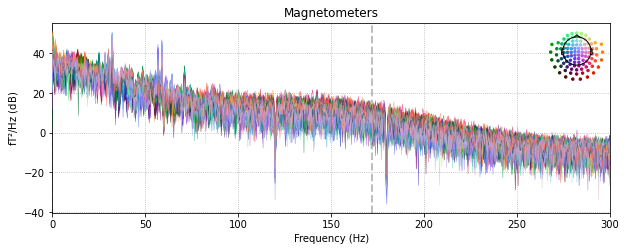

In [15]:
import numpy as np

raw.notch_filter(np.arange(60, 181, 60), picks='mag', filter_length='auto', # we remove AC freq and its harmonics
                 phase='zero', verbose=False)
raw.plot_psd(area_mode='range', tmax=10.0, picks='mag', average=False);

If we are only interested in the low frequencies, we can also remove the AC artifact by simply cutting high frequencies (low-pass filtering)

Effective window size : 3.410 (s)


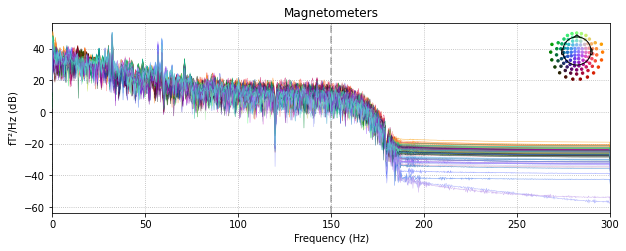

In [16]:
raw.filter(None, 150., fir_design='firwin', verbose=False)
raw.plot_psd(area_mode='range', tmax=10.0, picks='mag', average=False);

And to remove slow drifts, we can cut the low frequencies (high-pass)

Effective window size : 3.410 (s)


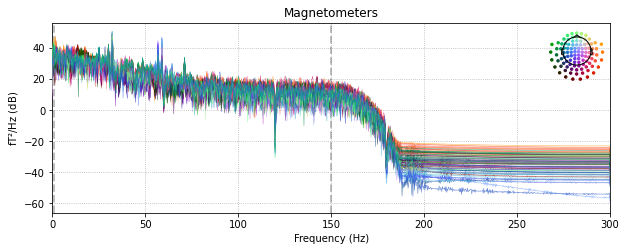

In [17]:
raw.filter(1., None, fir_design='firwin', verbose=False)
raw.plot_psd(area_mode='range', tmax=10.0, picks='mag', average=False);

Signal correction by ICA
=============================

We want to decompose our data $X \in \mathbb{R}^{C \times T}$

$$ X = As $$ 

where $A \in \mathbb{R}^{C \times C}$ is the mixing matrix and $s \in \mathbb{R}^{C \times T}$ are the (independant) latent sources

First, a 1Hz high pass is often helpful for fitting ICA

In [18]:
raw.filter(1., None, n_jobs=1, fir_design='firwin', verbose=False)

<Raw | sample_audvis_raw.fif, 374 x 30032 (50.0 s), ~89.0 MB, data loaded>

Now let's look at a quick example

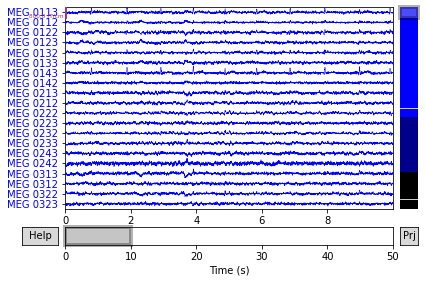

Fitting ICA to data using 362 channels (please be patient, this may take a while)
Selecting by number: 25 components
Fitting ICA took 4.4s.
Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 1 ICA component
    Projecting back using 362 PCA components


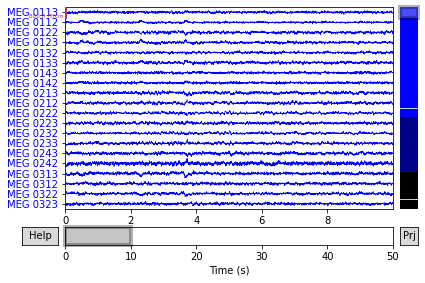

In [19]:
from mne.preprocessing import ICA

raw.plot();
ica = ICA(n_components=25, method='fastica', random_state=23).fit(raw)
ica.exclude = [1]
raw_clean = ica.apply(raw.copy())
raw_clean.plot();

Fit ICA
-------

First, choose the ICA method. There are currently four possible choices:
`fastica`, `picard`, `infomax` and `extended-infomax`.

In [20]:
method = 'fastica'

# Choose other parameters
n_components = 25  # if float, select n_components by explained variance of PCA
decim = 3  # we need sufficient statistics, not all time points -> saves time

ICA is a non-deterministic algorithm, but we want to have the same decomposition
and the same order of components

In [21]:
random_state = 23

Define the ICA object instance

In [22]:
ica = ICA(n_components=n_components, method=method, random_state=random_state)
print(ica)

<ICA | no decomposition, fit (fastica):  samples, no dimension reduction>


We avoid fitting ICA on crazy environmental artifacts that would
dominate the variance and decomposition

In [23]:
reject = dict(mag=5e-12, grad=4000e-13)

picks_meg = mne.pick_types(raw.info, meg=True, eeg=False, eog=False,
                           stim=False, exclude='bads')
ica.fit(raw, picks=picks_meg, decim=decim, reject=reject)
print(ica)

Fitting ICA to data using 304 channels (please be patient, this may take a while)
Selecting by number: 25 components
Fitting ICA took 2.0s.
<ICA | raw data decomposition, fit (fastica): 9624 samples, 25 components, channels used: "mag"; "grad">


Now plot the ICA components

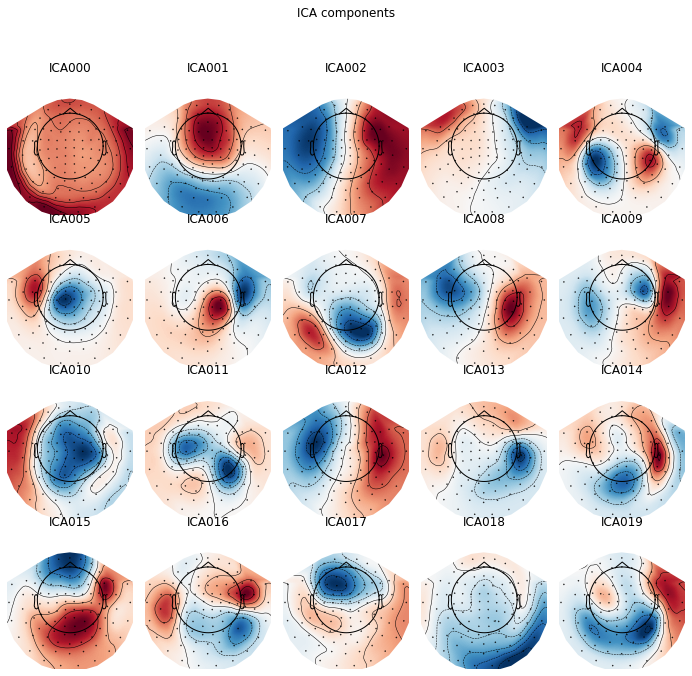

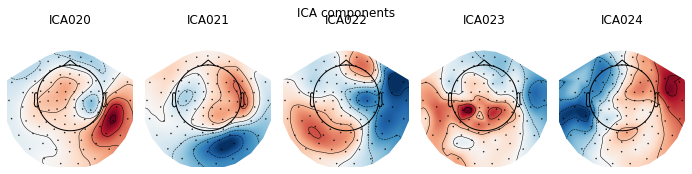

In [24]:
ica.plot_components();  # can you spot some potential bad guys?

Creating RawArray with float64 data, n_channels=26, n_times=30032
    Range : 25800 ... 55831 =     42.956 ...    92.956 secs
Ready.


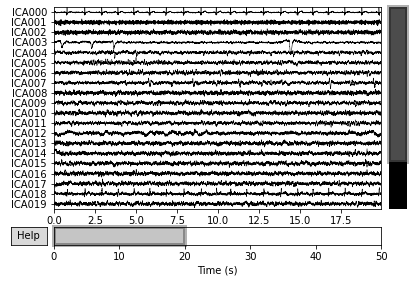

In [25]:
ica.plot_sources(raw);

Let's take a closer look at properties of first few independent components.


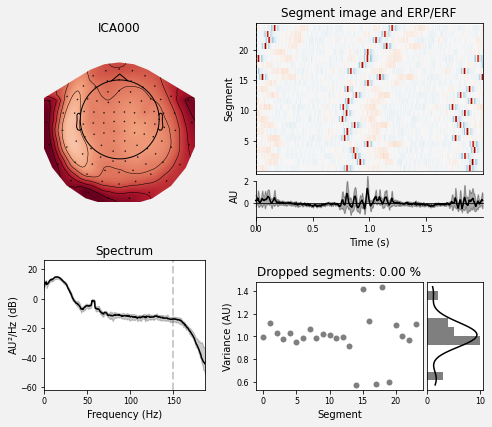

[<Figure size 504x432 with 6 Axes>]

In [26]:
ica.plot_properties(raw, picks=0, verbose=False)

Advanced artifact detection
---------------------------

We can use a more efficient way to find artifactual components

EOG channel index for this subject is: [373]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 6007 samples (10.001 sec)

Now detecting blinks and generating corresponding events
Found 8 significant peaks
Number of EOG events detected : 8
Not setting metadata
Not setting metadata
8 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 4)
Loading data for 8 events and 601 original time points ...
0 bad epochs dropped


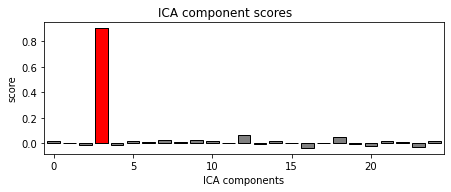

In [27]:
from mne.preprocessing import create_eog_epochs

eog_epochs = create_eog_epochs(raw, reject=reject)  # get single EOG trial
eog_inds, scores = ica.find_bads_eog(eog_epochs)  # find via correlation

ica.plot_scores(scores, exclude=eog_inds);  # look at r scores of components


We take a look at the properties of that component, now using the
data epoched with respect to EOG events.
We will also use a little bit of smoothing along the trials axis in the
epochs image:


    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
8 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


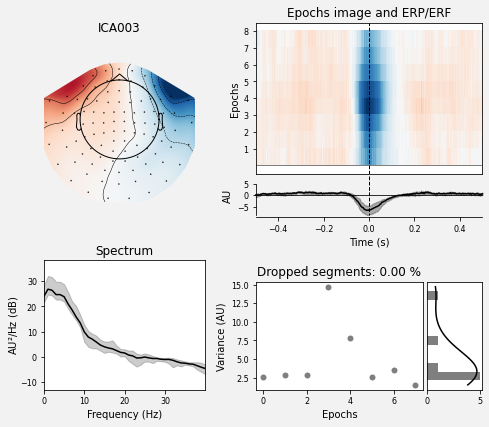

[<Figure size 504x432 with 6 Axes>]

In [28]:
ica.plot_properties(eog_epochs, picks=eog_inds, psd_args={'fmax': 40.},
                    image_args={'sigma': 1.})

Reconstructing ECG signal from Magnetometers
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 6007 samples (10.001 sec)

Number of ECG events detected : 49 (average pulse 58 / min.)
Not setting metadata
Not setting metadata
49 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 4)
Loading data for 49 events and 601 original time points ...
0 bad epochs dropped
Reconstructing ECG signal from Magnetometers
Using threshold: 0.21 for CTPS ECG detection


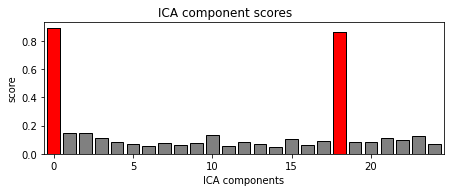

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
49 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
49 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


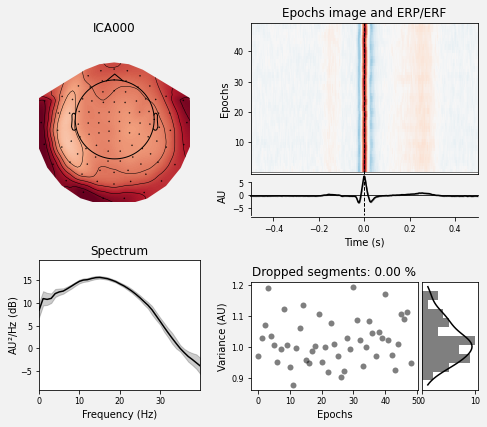

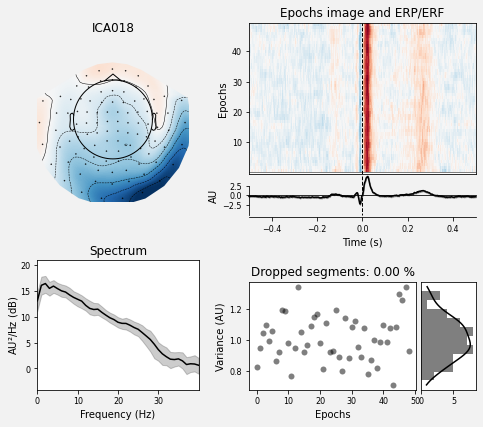

In [29]:
#Let's do the same for cardiac activity :
from mne.preprocessing import create_ecg_epochs

ecg_epochs = create_ecg_epochs(raw, reject=reject)  # get single EOG trials
ecg_inds, scores = ica.find_bads_ecg(ecg_epochs)  # find via correlation

ica.plot_scores(scores, exclude=ecg_inds);  # look at r scores of components
ica.plot_properties(ecg_epochs, picks=ecg_inds, psd_args={'fmax': 40.},
                    image_args={'sigma': 1.});

Note that nothing is yet removed from the raw data. To remove the effects of
the rejected components, `mne.preprocessing.ICA.apply` must be called.

Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 3 ICA components
    Projecting back using 304 PCA components


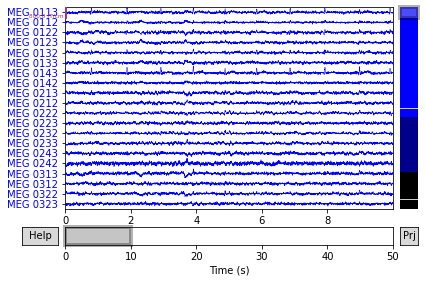

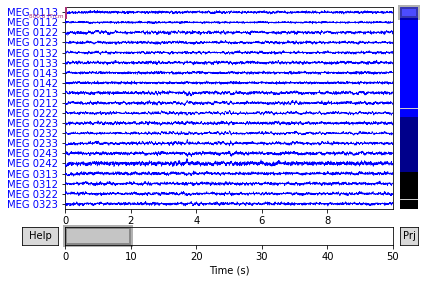

In [30]:
ica.exclude.extend(eog_inds) # the exclude attribute keeps track of the components to be excluded
ica.exclude.extend(ecg_inds)

raw_copy = raw.copy()
ica.apply(raw_copy)
raw.plot();
raw_copy.plot();  # check the result

Tuning rejection thresholds
---------------------------

First we're gonna need a dataset with more epochs

In [31]:
from mne.datasets import sample
data_path = sample.data_path()
raw_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'
raw = mne.io.read_raw_fif(raw_fname, preload=True)  # already has an EEG ref

Opening raw data file C:\Users\yhare\mne_data\MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Reading 0 ... 41699  =      0.000 ...   277.709 secs...


We are going to segment our data, so we need to set up some parameters

In [32]:
events = mne.find_events(raw, stim_channel='STI 014')
event_id = {"auditory/left": 1}
tmin, tmax = -0.2, 0.5
baseline = (None, 0)  # means from the first instant to t = 0

319 events found
Event IDs: [ 1  2  3  4  5 32]


Now perform the segmentation without setting the reject argument (wait and see...)

In [33]:
picks = mne.pick_types(raw.info, meg=False, eeg=True)
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True,
                    picks=picks, baseline=baseline, reject=None,                   
                    preload=True)



Not setting metadata
Not setting metadata
72 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] sec
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
4 projection items activated
Loading data for 72 events and 106 original time points ...
0 bad epochs dropped


Here's the trick : an interactive plot to see how changing the rejection threshold affects the evoked potential.

In [34]:
from ipywidgets import interact
def reject_epochs(reject):
    reject = dict(eeg=reject * 1e-6)
    evoked = epochs.copy().drop_bad(reject=reject, verbose=False).average()
    evoked.plot(spatial_colors=True, verbose=False)
    print('Number of epochs retained: %d/%d' % (evoked.nave, len(epochs)))

In [35]:
interact(reject_epochs, reject=(35, 250, 10));

interactive(children=(IntSlider(value=135, description='reject', max=250, min=35, step=10), Output()), _dom_cl…

The question is then : how to decide which threshold is optimal ?

Autoreject
----------

Autoreject (global) can compute the rejection dictionary automatically

In [36]:
from autoreject import get_rejection_threshold  # noqa
reject = get_rejection_threshold(epochs)
print(reject)

Estimating rejection dictionary for eeg
{'eeg': 8.632629511745276e-05}


Even better : AutoReject can compute different thresholds for each channel. To do that we need to create an AR object.

In [37]:
from autoreject import AutoReject

n_interpolates = np.array([1, 2, 4])
consensus = np.linspace(0.5, 1.0, 6)

ar = AutoReject(n_interpolates, consensus, thresh_method='random_search',
                random_state=42)

In [38]:
# Note that fitting and transforming can be done on different compatible
# portions of data if needed.
ar.fit(epochs['auditory/left'])

Running autoreject on ch_type=eeg








Estimated consensus=0.60 and n_interpolate=4


AutoReject(consensus=array([0.5, 0.6, 0.7, 0.8, 0.9, 1. ]), cv=10,
      n_interpolate=array([1, 2, 4]), n_jobs=1, picks=None,
      random_state=42, thresh_method='random_search',
      verbose='progressbar')

In [39]:
for ch_name in epochs.info['ch_names'][:5]:
     print('%s: %s' % (ch_name, ar.threshes_[ch_name]))

# plt.hist(np.array(list(ar.threshes_.values())), 30, color='g', alpha=0.4)

EEG 001: 8.060712098512445e-05
EEG 002: 6.193859518896799e-05
EEG 003: 4.1820624263652974e-05
EEG 004: 5.066574834062146e-05
EEG 005: 5.342944690046495e-05


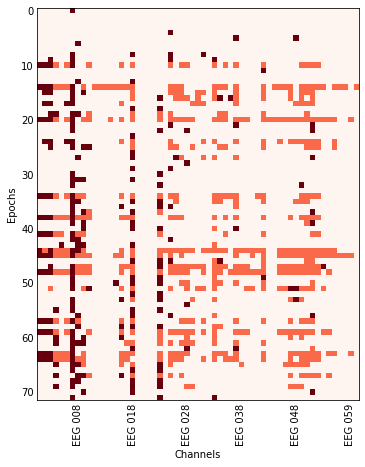

In [40]:
reject_log = ar.get_reject_log(epochs['auditory/left'])
reject_log.plot();

Another way to visualize this is to plot them on the epochs

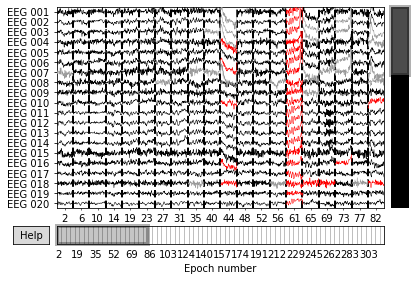

In [41]:
reject_log.plot_epochs(epochs['auditory/left']);

We can apply these rejection thresholds to new (or to the old) data:

In [42]:
epochs_clean = ar.transform(epochs['auditory/left'])


Dropped 4 epochs: 14, 20, 44, 48


Removing projector <Projection | PCA-v1, active : True, n_channels : 102>
Removing projector <Projection | PCA-v2, active : True, n_channels : 102>
Removing projector <Projection | PCA-v3, active : True, n_channels : 102>


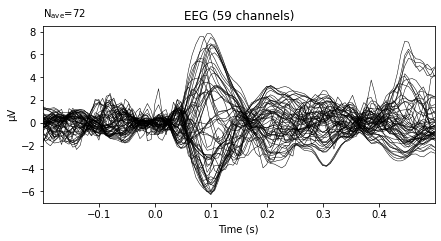

Removing projector <Projection | PCA-v1, active : True, n_channels : 102>
Removing projector <Projection | PCA-v2, active : True, n_channels : 102>
Removing projector <Projection | PCA-v3, active : True, n_channels : 102>


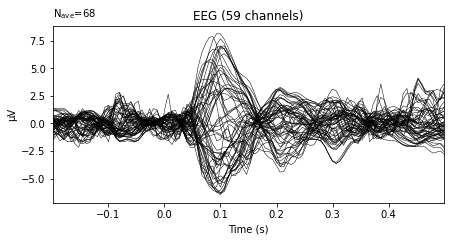

In [43]:
evoked = epochs['auditory/left'].average()
evoked.plot(exclude=[]);

evoked_clean = epochs_clean.average()
evoked_clean.plot(exclude=[]);

## Now it's your time to start playing with data !

There are plenty of open datasets online :
    

- [OpenNeuro](https://openneuro.org/)
- [Human connectome project](https://www.humanconnectome.org/)
- [A cool list of public EEG datasets](https://github.com/meagmohit/EEG-Datasets)

### You might need additional ressources in your quest

- [Mainak Jas' tutorials](https://jasmainak.github.io/mne-workshop-brown/readme)

- [MNE Python tutorials](https://mne.tools/stable/auto_tutorials/index.html)

- For neuroscience-related questions : [Neurostars](https://neurostars.org/)

### Thanks

- Mainak Jas
- Gabrielle Toupin
- The Brainhack team

Find me : yharel109@gmail.com

To cite the MNE-Python package, please use:

```
A. Gramfort, M. Luessi, E. Larson, D. Engemann, D. Strohmeier, C. Brodbeck, R. Goj, M. Jas, T. Brooks, L. Parkkonen, M. Hämäläinen, MEG and EEG data analysis with MNE-Python, Frontiers in Neuroscience, Volume 7, 2013, ISSN 1662-453X, [DOI]
```